<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/experiment/gan_style_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load data

In [1]:
import pandas as pd
import joblib
from urllib.request import urlopen
import numpy as np

df_url = 'https://c620.s3-ap-northeast-1.amazonaws.com/c620_train.csv'
c_url = 'https://c620.s3-ap-northeast-1.amazonaws.com/c620_col_names.pkl'

df = pd.read_csv(df_url,index_col=0)
c = joblib.load(urlopen(c_url))

case_col = c['case']
feed_col = c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] + c['distillate_sf'] + c['sidedraw_sf'] + c['bottoms_sf']
wt_col = c['vent_gas_x']+c['distillate_x']+c['sidedraw_x']+c['bottoms_x']
all_col = case_col + feed_col + op_col + sp_col + wt_col

print(len(case_col))
print(len(feed_col))
print(len(op_col))
print(len(sp_col))
print(len(wt_col))

df[all_col].head(1)

3
41
10
164
164


,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%
001-001,36.0,0.5,89.999954,0.0,0.022867,0.552459,0.508704,0.152381,0.076394,0.015837,...,0.039314,0.001123,0.025835,1.009804,0.0,1.161444,0.297662,0.128051,0.0,0.0


In [2]:
case_col_idx = [all_col.index(i) for i in case_col]
feed_col_idx = [all_col.index(i) for i in feed_col]
op_col_idx = [all_col.index(i) for i in op_col]
sp_col_idx = [all_col.index(i) for i in sp_col]
wt_col_idx = [all_col.index(i) for i in wt_col]

# preprocess data

In [23]:
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch

# split data
df = shuffle(df)
p1 = int(len(df)*0.8)
p2 = int(len(df)*0.9)

# to FloatTensor
train = torch.FloatTensor(df[all_col].values[:p1])
vaild = torch.FloatTensor(df[all_col].values[p1:p2])
test = torch.FloatTensor(df[all_col].values[p2:])

# create DataLoader
trainset = TensorDataset(train[:,case_col_idx],train[:,feed_col_idx],train[:,op_col_idx],train[:,sp_col_idx],train[:,wt_col_idx])
train_iter = DataLoader(trainset,batch_size=64)

vaildset = TensorDataset(vaild[:,case_col_idx],vaild[:,feed_col_idx],vaild[:,op_col_idx],vaild[:,sp_col_idx],vaild[:,wt_col_idx])
vaild_iter = DataLoader(vaildset,batch_size=64)

testset = TensorDataset(test[:,case_col_idx],test[:,feed_col_idx],test[:,op_col_idx],test[:,sp_col_idx],test[:,wt_col_idx])
test_iter = DataLoader(testset,batch_size=64)

# def model,loss,optimizer

In [24]:
import torch
from torch import nn
import torch.nn.functional as F

def mlp(sizes, activation, output_activation=nn.Identity):
  layers = []
  for j in range(len(sizes)-1):
    act = activation if j < len(sizes)-2 else output_activation
    layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
  return nn.Sequential(*layers)

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.op_model = mlp(
      [len(case_col)+len(feed_col),128,len(op_col)],
      nn.ReLU
      )
    self.sp_model = mlp(
      [len(case_col)+len(feed_col)+len(op_col),128,len(wt_col)],
      nn.ReLU,
      nn.Sigmoid
      )

  def forward(self,case,feed):
    op = self.op_model(torch.cat((case,feed),dim=-1)).clone()
    sp = self.sp_model(torch.cat((case,feed,op),dim=-1)).clone()
    for idx in range(41):
      sp[:,[idx,idx+41,idx+41*2,idx+41*3]] = self.normalize(sp[:,[idx,idx+41,idx+41*2,idx+41*3]])
    s1,s2,s3,s4 = sp[:,:41],sp[:,41:41*2],sp[:,41*2:41*3],sp[:,41*3:41*4]
    w1,w2,w3,w4 = self.sp2wt(feed,s1),self.sp2wt(feed,s2),self.sp2wt(feed,s3),self.sp2wt(feed,s4)
    wt = torch.cat((w1,w2,w3,w4),dim=-1)
    return op,sp,wt

  @staticmethod
  def normalize(x):
    return x / x.sum(dim=1).reshape(-1,1)
  
  @staticmethod
  def sp2wt(x,s):
    a = 100*x*s
    b = torch.diag(x@s.T).reshape(-1,1)
    b = torch.clamp(b,1e-8,float('inf'))
    return a/b

# model optimizer loss_fn
model = Model()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.SmoothL1Loss()

# forward test
for case,feed,op,sp,wt in train_iter:
  op_hat,sp_hat,wt_hat = model(case,feed)
  print(op_hat.shape)
  print(sp_hat.shape)
  print(wt_hat.shape)
  break

torch.Size([64, 10])
torch.Size([64, 164])
torch.Size([64, 164])


# tensorboard

In [25]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
case,feed,op,sp,wt = next(iter(train_iter))
writer.add_graph(model,[case,feed])
writer.close()

In [27]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

# train model

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy

# train step
def train_step(model):
  model.train()
  total_loss = 0
  for t,(case,feed,op,sp,wt) in enumerate(train_iter):
    op_hat,sp_hat,wt_hat = model(case,feed)
    op_loss = loss_fn(op_hat,op)
    sp_loss = loss_fn(sp_hat,sp)
    wt_loss = loss_fn(wt_hat,wt)
    Sidedraw_Benzene_loss = loss_fn(
      wt_hat[:,wt_col.index('Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%')],
      case[:,case_col.index('Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%')])
    loss = op_loss + sp_loss + wt_loss + Sidedraw_Benzene_loss
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  return total_loss/(t+1)

# valid step
def valid_step(model):
  model.eval()
  total_loss = 0
  for t,(case,feed,op,sp,wt) in enumerate(vaild_iter):
    op_hat,sp_hat,wt_hat = model(case,feed)
    op_loss = loss_fn(op_hat,op)
    sp_loss = loss_fn(sp_hat,sp)
    wt_loss = loss_fn(wt_hat,wt)
    Sidedraw_Benzene_loss = loss_fn(
      wt_hat[:,wt_col.index('Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%')],
      case[:,case_col.index('Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%')])
    loss = op_loss + sp_loss + wt_loss + Sidedraw_Benzene_loss
    total_loss += loss.item()
  return total_loss/(t+1)

def train(model,max_epochs): 
  history = {'train_loss':[],'valid_loss':[]}
  current_loss = np.inf
  best_model = None
  for i in tqdm(range(max_epochs)):
      history['train_loss'].append(train_step(model))
      history['valid_loss'].append(valid_step(model))
      if i % 10 == 0:
        print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f}".format(i,history['train_loss'][-1],history['valid_loss'][-1]))
      if history['valid_loss'][-1] <= current_loss:
        best_model = deepcopy(model.eval())
        current_loss = history['valid_loss'][-1]
  model = deepcopy(best_model.eval())
  plt.plot(history['train_loss'],label='train_loss')
  plt.plot(history['valid_loss'],label='valid_loss')
  plt.legend()
  plt.show()
  return model

epoch:0 train_loss:30.5960 valid_loss:6.7879
epoch:10 train_loss:3.9204 valid_loss:4.4300
epoch:20 train_loss:3.2285 valid_loss:3.1838
epoch:30 train_loss:2.8730 valid_loss:2.7595
epoch:40 train_loss:2.2527 valid_loss:1.9093
epoch:50 train_loss:2.1410 valid_loss:1.8568
epoch:60 train_loss:1.8675 valid_loss:1.6475
epoch:70 train_loss:1.6547 valid_loss:1.4159
epoch:80 train_loss:0.1843 valid_loss:0.1582
epoch:90 train_loss:0.1098 valid_loss:0.1215
epoch:100 train_loss:0.0840 valid_loss:0.0407
epoch:110 train_loss:0.0405 valid_loss:0.0436
epoch:120 train_loss:0.0407 valid_loss:0.0342
epoch:130 train_loss:0.0508 valid_loss:0.0279
epoch:140 train_loss:0.0439 valid_loss:0.0262
epoch:150 train_loss:0.0389 valid_loss:0.0336
epoch:160 train_loss:0.0379 valid_loss:0.0248
epoch:170 train_loss:0.0403 valid_loss:0.0381
epoch:180 train_loss:0.0301 valid_loss:0.0516
epoch:190 train_loss:0.0225 valid_loss:0.0368
epoch:200 train_loss:0.0331 valid_loss:0.0321
epoch:210 train_loss:0.0234 valid_loss:0.023

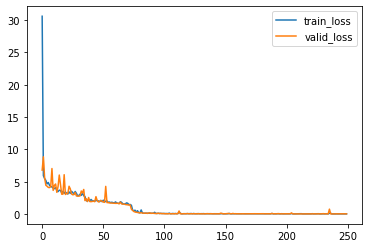

In [6]:
model = train(model,max_epochs=250)

In [7]:
op_pred,sp_pred,wt_pred = model(test[:,case_col_idx],test[:,feed_col_idx])

wt_pred = pd.DataFrame(wt_pred.detach().cpu().numpy(),columns=wt_col)
op_pred = pd.DataFrame(op_pred.detach().cpu().numpy(),columns=op_col)

wt_real = pd.DataFrame(test[:,wt_col_idx].detach().cpu().numpy(),columns=wt_col)
op_real = pd.DataFrame(test[:,op_col_idx].detach().cpu().numpy(),columns=op_col)

In [8]:
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

def mape(y_true, y_pred, e = 2e-2):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  mask = y_true > e
  y_true, y_pred = y_true[mask], y_pred[mask]
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def show_metrics(y_real,y_pred,e=2e-2):
  res = pd.DataFrame(index=y_pred.columns,columns=['R2','MSE','MAPE'])
  for i in y_pred.columns:
      res.loc[i,'R2'] = np.clip(r2_score(y_real[i],y_pred[i]),0,1)
      res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
      res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i],e)
  res.loc['AVG'] = res.mean(axis=0)
  return res

In [9]:
show_metrics(op_real,op_pred)

,R2,MSE,MAPE
Density_Feed Properties,0,1.03791e-05,0.317522
Density_Vent Gas Production Rate and Composition,0.616302,8.81954e-06,0.430217
Density_Distillate Production Rate and Composition,0,0.000204659,1.65112
Density_Sidedraw Production Rate and Composition,0,5.93567e-06,0.148649
Density_Bottoms Production Rate and Composition,0,1.44723e-05,0.359877
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.99895,0.134619,0.230071
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.998021,0.00230495,0.292438
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.998461,0.00248494,0.271822
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.960116,0.0541295,0.116995
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.995549,0.00359387,0.0232859


In [10]:
show_metrics(wt_real,wt_pred)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.860551,0.00183218,1.87597
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.987806,0.0406776,0.388348
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.965015,0.011611,0.247694
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.979919,0.0221738,1.22781
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.964649,9.88155e-05,1.70205
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999783,1.09992e-07,0.134213
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


In [11]:
case = pd.DataFrame(test[:,case_col_idx].detach().cpu().numpy(),columns=case_col)
case.iloc[:,[2]]

,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%
0,80.000000
1,70.000015
2,89.999992
3,90.000015
4,79.999992
...,...
1551,79.999992
1552,70.000008
1553,90.000000
1554,70.000000


In [12]:
wt_pred.iloc[:,[89]]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
0,80.018158
1,70.088745
2,90.017609
3,89.975349
4,80.005196
...,...
1551,80.022186
1552,70.041191
1553,90.020256
1554,70.050293


In [13]:
wt_real.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%
0,0.0,1.735580,40.854179,35.134911,8.539701,2.934831,0.194797,10.557825,0.015089,0.004484,...,0.040319,0.001152,0.026495,1.035620,0.0,1.191136,0.305272,0.131324,0.0,0.0
1,0.0,1.620795,38.780468,35.019016,9.910460,4.344801,0.268734,9.991651,0.014487,0.003978,...,0.041822,0.001195,0.027483,1.074230,0.0,1.235543,0.316653,0.136220,0.0,0.0
2,0.0,1.639932,39.672600,35.926533,10.281646,4.589512,0.209934,7.658463,0.010871,0.002477,...,0.063310,0.000908,0.024507,0.947716,0.0,1.091127,0.399940,0.171435,0.0,0.0
3,0.0,1.712373,40.439095,35.028820,8.778197,3.318513,0.202569,10.488806,0.015276,0.004234,...,0.063425,0.001133,0.024917,0.945715,0.0,1.089554,0.398673,0.171021,0.0,0.0
4,0.0,1.658153,39.844955,36.059849,10.189783,4.298722,0.232068,7.684918,0.010389,0.002540,...,0.040438,0.001155,0.026574,1.038681,0.0,1.194656,0.306174,0.131713,0.0,0.0


In [14]:
wt_pred.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%
0,0.0,1.774041,41.152180,35.296211,8.206505,2.666838,0.200860,10.644809,0.018999,0.010562,...,0.040395,0.001154,0.026545,1.036119,0.0,1.192058,0.305258,0.131573,0.0,0.0
1,0.0,1.672329,38.930836,35.044586,9.847038,4.266691,0.208767,9.931718,0.009511,0.000616,...,0.041802,0.001194,0.027469,1.073361,0.0,1.234092,0.316403,0.136150,0.0,0.0
2,0.0,1.646622,39.669861,35.833496,10.270977,4.709546,0.214840,7.630282,0.013033,0.000136,...,0.063336,0.000908,0.024517,0.913062,0.0,1.086496,0.379279,0.171507,0.0,0.0
3,0.0,1.757410,41.062080,35.231461,8.188355,3.062904,0.190663,10.471148,0.022316,0.004287,...,0.063413,0.001132,0.024912,0.910664,0.0,1.083871,0.379407,0.170987,0.0,0.0
4,0.0,1.677656,39.880451,36.085148,10.167580,4.182552,0.221186,7.754416,0.008566,0.000176,...,0.040514,0.001158,0.026624,1.039162,0.0,1.195719,0.306067,0.131960,0.0,0.0


In [15]:
op_real.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
0,0.862201,0.451699,0.807672,0.880111,0.871891,114.949593,12.014245,13.654127,176.768524,193.888947
1,0.862264,0.456571,0.796792,0.878735,0.871920,103.718544,10.510809,12.042009,177.670349,194.060547
2,0.864572,0.451205,0.779997,0.881553,0.872119,143.293716,14.340211,16.338280,175.403900,192.173981
3,0.864624,0.452764,0.805388,0.881624,0.872110,132.359253,13.705202,15.249033,175.303009,191.970703
4,0.862092,0.450669,0.781604,0.880023,0.871907,130.455917,13.094102,15.508738,176.947662,194.274536


In [16]:
op_pred.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
0,0.858564,0.450769,0.793369,0.882788,0.876063,114.955109,12.008997,13.683111,176.448822,193.894043
1,0.857896,0.458221,0.779735,0.877358,0.875578,104.124573,10.500270,12.045412,177.690964,194.013779
2,0.862302,0.451794,0.763688,0.881063,0.873262,143.472870,14.363647,16.391787,175.469650,192.157700
3,0.860319,0.449724,0.801924,0.885162,0.880900,132.118790,13.735847,15.254994,175.383408,191.930298
4,0.860176,0.452232,0.761698,0.879457,0.872352,130.336243,13.094616,15.464966,176.664200,194.313385
